<p style="text-align:center">
PSY 381D <b>Brain Connectivity</b>, Spring 2019


<img style="width: 700px; padding: 0px;" src="https://github.com/sathayas/JupyterConnectivitySpring2019/blob/master/Images/Banner.png?raw=true" alt="title pics"/>

</p>

<p style="text-align:center; font-size:40px; margin-bottom: 30px;"><b> Rich club / K-core </b></p>

<p style="text-align:center; font-size:18px; margin-bottom: 32px;"><b>February 25, 2019</b></p>

<hr style="height:5px;border:none" />

# 1. Network data
<hr style="height:1px;border:none" />

We will examine these network data for today's exercises. They are available in the **`DataRichClub`** directory.
* Dolphin social network (`dolphins.gml`)
* Brain network (resting-state fMRI, ROI, Berlin), formed with different numbers of edges:
   * d=5 (`Berlin_sub91116_aal90_d5_annotated.adjlist`)
   * d=10 (`Berlin_sub91116_aal90_d10_annotated.adjlist`)
   * d=15 (`Berlin_sub91116_aal90_d15_annotated.adjlist`)

# 2. Rich club
<hr style="height:1px;border:none" />

## 2.1 Dolphin social network

Rich club coefficients of a network can be determined easily by the **`rich_club_coefficient`** function in `networkX`. Let's examine this in the dolphin social network data.

`<RichClubDolphin.py>`

In [1]:
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


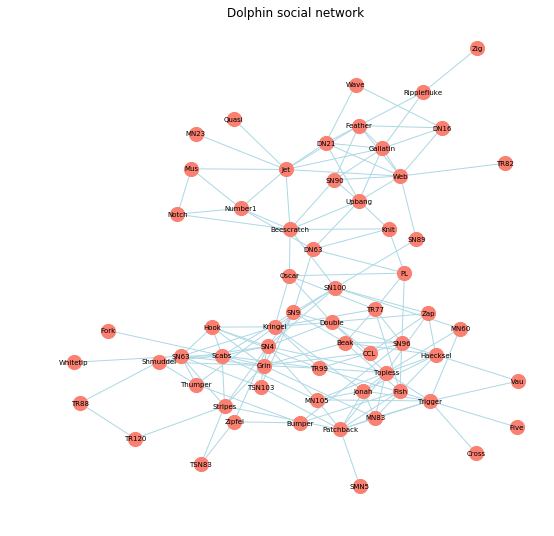

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random


##### loading the network data
H = nx.read_gml('DataRichClub/dolphins.gml')
# extracting giant component nodes
GCnodes = max(nx.connected_components(H), key=len)  
# giant component as a network
G = H.subgraph(GCnodes)   



###### drawing the graph --- Kamada-Kawai layout
plt.figure(figsize=[9,9])
pos = nx.kamada_kawai_layout(G, weight=None) # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_color='salmon', node_size=200)
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')
plt.axis('off')
plt.title('Dolphin social network')
plt.show()


In [3]:
len(G.nodes())

62

In [4]:
len(G.edges())

159

The rich club coefficients for this network are:

In [7]:
##### Rich club coefficient (original network)
RCdict = nx.rich_club_coefficient(G, normalized=False)

It returns a dictionary object, with the keys corresponding to node degrees and the values corresponding to rich club coefficients.

In [6]:
RCdict

{0: 0.08408249603384453,
 1: 0.10885341074020319,
 2: 0.12858464384828863,
 3: 0.15121951219512195,
 4: 0.16984126984126985,
 5: 0.20634920634920634,
 6: 0.23157894736842105,
 7: 0.21794871794871795,
 8: 0.2222222222222222,
 9: 0.5,
 10: 0.6666666666666666}

In [8]:
# extracting the degree and rich club coeff from the dictionary
K = [k for k, rc in RCdict.items()]
RCorig = [rc for k, rc in RCdict.items()]

We keep these rich club coefficients as **`RCorig`** for now. To determine whether these coefficients are large, we need to compare them to that from the equivalent random networks. Recall we generated equivalent random networks with the same degree sequence, when we talked about small-world networks? We will do the same thing here. Here are the functions needed to generate random networks.

In [9]:
##### network rewiring functions -- used to generate random network models
def pick_4nodes(G):
    a = random.choice(list(G.nodes()))  # a random node
    b = random.choice(list(G[a]))       # a random node connected to a
    while True:
        # potential pool of nodes to draw c
        cPool = (set(G.nodes())-set(G[a])).intersection(set(G.nodes())-set(G[b]))
        c = random.choice(list(cPool))
        # potential pool of nodes to draw d
        dPool = (set(G[c])-set(G[a])).intersection(set(G[c])-set(G[b]))
        if len(dPool)>0:
            d = random.choice(list(dPool))
            break
    return [a,b,c,d]


def rewire_multi(G,nIter):
    H = G.copy()
    for i in range(nIter):
        list4nodes = pick_4nodes(H)
        H.remove_edge(list4nodes[0],list4nodes[1])
        H.remove_edge(list4nodes[2],list4nodes[3])
        H.add_edge(list4nodes[0],list4nodes[2])
        H.add_edge(list4nodes[1],list4nodes[3])
    return H


Using these functions, we generate equivalent random networks, 200 times. For each iteration, we record the rich club coefficients of the generated network. After 200 iterations, we can calculate the average rich club coefficients from equivalent random networks (we refer these **`RCrand`**). 

In [10]:
##### Rich club coefficient (random network)
RCrand = np.zeros_like(RCorig)
nIter = 200 # number of random networks to be generated
print('Generating random networks ')
for iIter in range(nIter):
    print('.',end='')
    if (iIter+1)%20 == 0:
        print()

    # first generating a random network
    Grand = rewire_multi(G, 10*len(G.nodes()))

    # rich club coefficient of the random network
    RCrandDict = nx.rich_club_coefficient(Grand, normalized=False)

    # extracting rich club coeff from the dictionary
    tmpRC = np.array([rc for k, rc in RCrandDict.items()])
    RCrand += tmpRC

print('done!')
# dividing RC by the number of iterations to get the average
RCrand /= nIter

Generating random networks 
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
done!


Then we can calculate the normalized rich club coefficients by dividing the original RC by the RC from the random networks. 

In [11]:
##### Rich club coefficient (original vs random)
RCnorm = np.array(RCorig) / RCrand

Let's plot these and see if **`RCnorm`** is greater than 1.

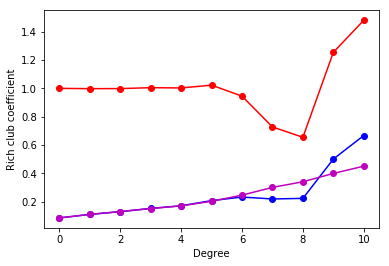

In [12]:
##### Finally plotting the rich club coefficients
plt.plot(K,RCorig,'bo-', label='Original network')
plt.plot(K,RCrand,'mo-', label='Random network')
plt.plot(K,RCnorm,'ro-', label='Normalized RC')
plt.xlabel('Degree')
plt.ylabel('Rich club coefficient')
plt.show()

So it appears that the rich club phenomenon can be observed for nodes with degrees 9 or 10. So let's extract the subnetwork formed by these rich club nodes.

In [13]:
##### Extracting the rich club network
RCthresh = 1.10  # if RCnorm is greater than this, rich club for sure
K_RC_min = K[np.min(np.where(RCnorm>RCthresh))]  # min degree for rich club
K_RC_max = K[np.max(np.where(RCnorm>RCthresh))]  # max degree for rich club
# extracting the nodes whose degree within the range of the rich club
nodes_RC = [node for node, degree in dict(G.degree()).items() 
            if K_RC_min<=degree<=K_RC_max]
G_RC = G.subgraph(nodes_RC)
# removing unconnected nodes
node_K0 = [node for node, degree in dict(G_RC.degree()).items()
           if degree==0]
H_RC = G_RC.copy()
H_RC.remove_nodes_from(node_K0)

One thing to note here is that we need to remove any isolated high-degree nodes; such nodes are not involved in high-degree connections, so likely not part of the rich club. Here is the rich club of the dolphin social network.

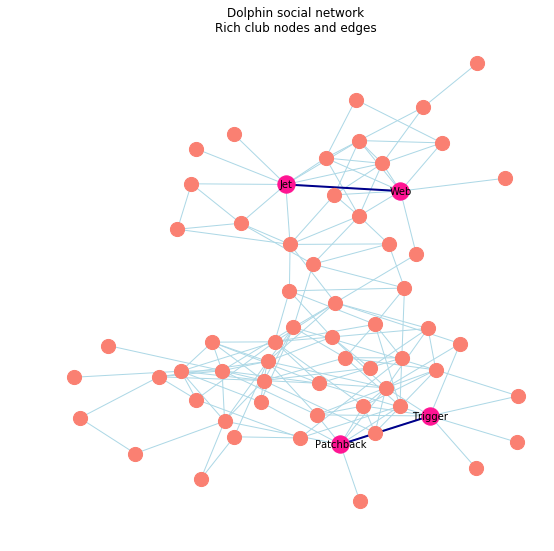

In [15]:
###### drawing the graph (rich club only) --- Kamada-Kawai layout
plt.figure(figsize=[9,9])

nx.draw_networkx_nodes(G, pos, node_color='salmon', node_size=200)
nx.draw_networkx_nodes(H_RC, pos, node_color='deeppink')
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
nx.draw_networkx_edges(H_RC, pos, width=2.0, edge_color='darkblue')
nx.draw_networkx_labels(H_RC, pos, font_size=10, font_color='black')
plt.axis('off')
plt.title('Dolphin social network\nRich club nodes and edges')
plt.show()


It turned out, the rich club is very limited in this network; in fact, only 4 nodes belong to the rich club.

## 2.2 Brain network

We can essentially do the similar type of analysis on a brain network. In this case, we shall examine the brain network data
```
Berlin_sub91116_aal90_d5_annotated.adjlist
```

So let's load the network data and plot the network in the brain space.

`<RichClubBrainBerlin.py>`

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


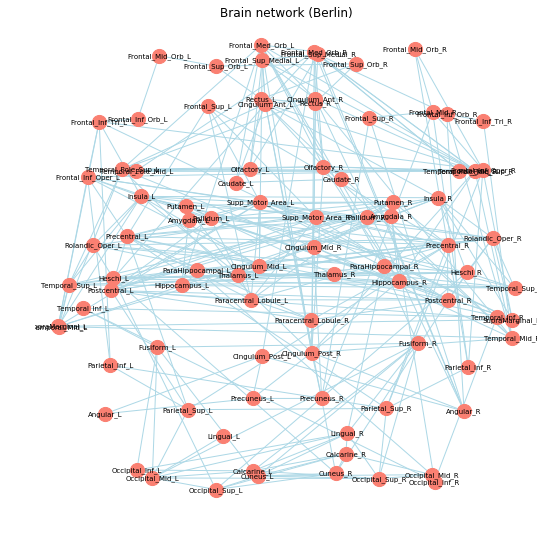

In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

##### loading the network data
H = nx.read_adjlist('DataRichClub/Berlin_sub91116_aal90_d5_annotated.adjlist')
# extracting giant component nodes
GCnodes = max(nx.connected_components(H), key=len)  
# giant component as a network
G = H.subgraph(GCnodes)   


###### drawing the graph --- in the brain space
# loading the coordinates info for brain areas
AALTable = pd.read_csv('DataRichClub/aal_MNI_V4_coord.csv')
# dictionary of xy-coordinates
pos = {}
for i in range(1,91):
    pos[AALTable.iloc[i-1,1]] = np.array(AALTable.loc[i-1,
                                                      ['centerX',
                                                       'centerY']])

# Actual drawing
plt.figure(figsize=[9,9])
nx.draw_networkx_nodes(G, pos, node_color='salmon', node_size=200)
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')
plt.axis('off')
plt.title('Brain network (Berlin)')
plt.show()

Now the rich club coefficients. First, for the original networks.

In [17]:
##### Rich club coefficient (original network)
RCdict = nx.rich_club_coefficient(G, normalized=False)

# extracting the degree and rich club coeff from the dictionary
K = [k for k, rc in RCdict.items()]
RCorig = [rc for k, rc in RCdict.items()]


And the equivalent random networks. Here, we generate random networks too.

In [18]:
##### Rich club coefficient (random network)
RCrand = np.zeros_like(RCorig)
nIter = 200 # number of random networks to be generated
print('Generating random networks ')
for iIter in range(nIter):
    print('.',end='')
    if (iIter+1)%20 == 0:
        print()

    # first generating a random network
    Grand = rewire_multi(G, 10*len(G.nodes()))

    # rich club coefficient of the random network
    RCrandDict = nx.rich_club_coefficient(Grand, normalized=False)

    # extracting rich club coeff from the dictionary
    tmpRC = np.array([rc for k, rc in RCrandDict.items()])
    RCrand += tmpRC

print('done!')
# dividing RC by the number of iterations to get the average
RCrand /= nIter


##### Rich club coefficient (original vs random)
RCnorm = np.array(RCorig) / RCrand

Generating random networks 
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
done!


Now let's plot the normalized rich club coefficients.

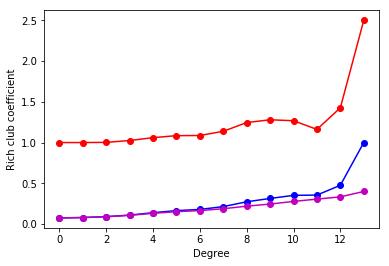

In [19]:
##### Finally plotting the rich club coefficients
plt.plot(K,RCorig,'bo-', label='Original network')
plt.plot(K,RCrand,'mo-', label='Random network')
plt.plot(K,RCnorm,'ro-', label='Normalized RC')
plt.xlabel('Degree')
plt.ylabel('Rich club coefficient')
plt.show()

Now let's extract the rich club sub-network. Here, we use the criterion RC>1.2 just to be sure of the rich clubness. And also removing isolated high-degree nodes not involved in high-degree connections.

In [20]:
##### Extracting the rich club network
RCthresh = 1.20  # if RCnorm is greater than this, rich club for sure
K_RC_min = K[np.min(np.where(RCnorm>RCthresh))]
K_RC_max = K[np.max(np.where(RCnorm>RCthresh))]
# extracting the nodes whose degree within the range of the rich club
nodes_RC = [node for node, degree in dict(G.degree()).items() 
            if K_RC_min<=degree<=K_RC_max]
G_RC = G.subgraph(nodes_RC)
# removing unconnected nodes
node_K0 = [node for node, degree in dict(G_RC.degree()).items()
           if degree==0]
H_RC = G_RC.copy()
H_RC.remove_nodes_from(node_K0)

Let's draw the rich club network.

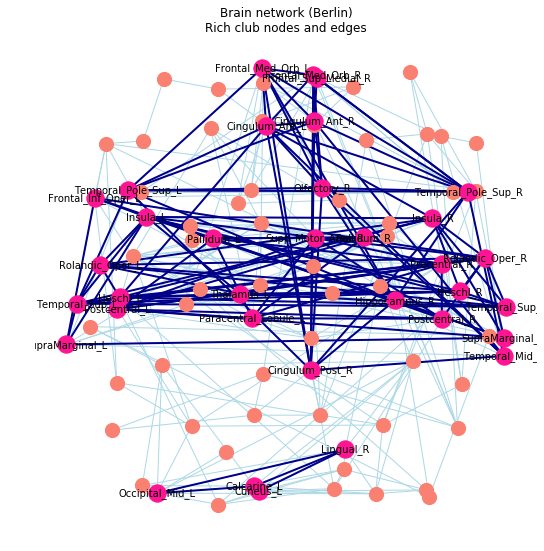

In [21]:
###### drawing the graph (rich club only) --- Brain space
plt.figure(figsize=[9,9])

nx.draw_networkx_nodes(G, pos, node_color='salmon', node_size=200)
nx.draw_networkx_nodes(H_RC, pos, node_color='deeppink')
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
nx.draw_networkx_edges(H_RC, pos, width=2.0, edge_color='darkblue')
nx.draw_networkx_labels(H_RC, pos, font_size=10, font_color='black')
plt.axis('off')
plt.title('Brain network (Berlin)\nRich club nodes and edges')
plt.show()

### Exercise
**Rich club, brain network**. Examine the rich club subnetwork of the brain network with higher edge density (d10 or d15). Produce a network drawing of the rich club nodes (similar to the one above) and post it as an attachment on the discussion on Canvas. Does an increase in the edge density expand the rich club?

# 3. K-core
<hr style="height:1px;border:none" />

A **K-core** of a network is a subnetwork with nodes whose degrees are K or larger. This can be determined by recursively removing nodes with small degrees (e.g., removing nodes with degree k=1, k=2, k=3, and so on).

<img style="width: 300px; padding: 0px;" src="https://github.com/sathayas/JupyterConnectivitySpring2019/blob/master/Images/KCore_schematic.png?raw=true" alt="K-Core schematic"/>

Why do we care about K-cores? K-cores with higher K may represent the core of a network.


## 3.1 Dolphin social network

Different K-cores can be determined by the function **`core_number`** in `networkX`. This function returns a core number for each node, indicating which k-core that node belongs to. We shall examine this in the dolphin social network again.

`<KCoreDolphin.py>`

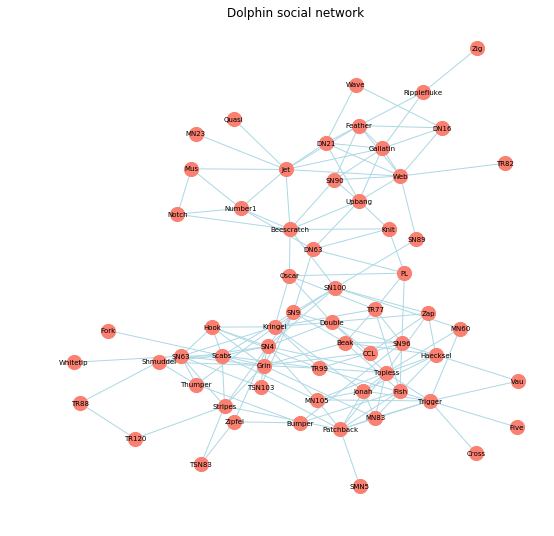

In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


##### loading the network data
H = nx.read_gml('DataRichClub/dolphins.gml')
# extracting giant component nodes
GCnodes = max(nx.connected_components(H), key=len)  
# giant component as a network
G = H.subgraph(GCnodes)   


###### drawing the graph --- Kamada-Kawai layout
plt.figure(figsize=[9,9])
pos = nx.kamada_kawai_layout(G, weight=None) # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_color='salmon', node_size=200)
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')
plt.axis('off')
plt.title('Dolphin social network')
plt.show()


As I mentioned earlier, core numbers are returned as a dictionary-like object.

In [25]:
##### K-core number
KcoreDict = nx.core_number(G)

In [26]:
KcoreDict

{'Beak': 4,
 'Beescratch': 4,
 'Bumper': 3,
 'CCL': 3,
 'Cross': 1,
 'DN16': 3,
 'DN21': 4,
 'DN63': 4,
 'Double': 4,
 'Feather': 4,
 'Fish': 4,
 'Five': 1,
 'Fork': 1,
 'Gallatin': 4,
 'Grin': 4,
 'Haecksel': 4,
 'Hook': 4,
 'Jet': 4,
 'Jonah': 4,
 'Knit': 4,
 'Kringel': 4,
 'MN105': 4,
 'MN23': 1,
 'MN60': 3,
 'MN83': 4,
 'Mus': 3,
 'Notch': 3,
 'Number1': 3,
 'Oscar': 4,
 'Patchback': 4,
 'PL': 4,
 'Quasi': 1,
 'Ripplefluke': 2,
 'Scabs': 4,
 'Shmuddel': 3,
 'SMN5': 1,
 'SN100': 4,
 'SN4': 4,
 'SN63': 4,
 'SN89': 2,
 'SN9': 4,
 'SN90': 4,
 'SN96': 4,
 'Stripes': 4,
 'Thumper': 3,
 'Topless': 4,
 'TR120': 2,
 'TR77': 4,
 'TR82': 1,
 'TR88': 2,
 'TR99': 4,
 'Trigger': 4,
 'TSN103': 4,
 'TSN83': 2,
 'Upbang': 4,
 'Vau': 2,
 'Wave': 2,
 'Web': 4,
 'Whitetip': 1,
 'Zap': 4,
 'Zig': 1,
 'Zipfel': 2}

In [27]:
listCoreNum = [kc for kc in KcoreDict.values()]
minKCore = min(listCoreNum)
maxKCore = max(listCoreNum)

Now we can draw the network with the k-core numbers. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

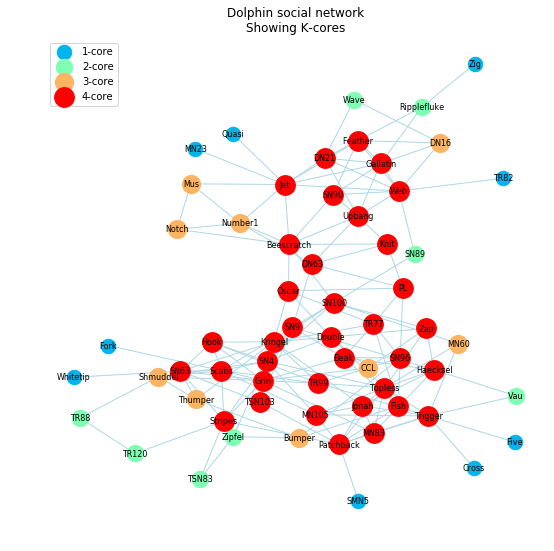

In [28]:
###### drawing the graph --- Kamada-Kawai layout
node_color_list = get_cmap(maxKCore+1,'rainbow')
plt.figure(figsize=[9,9])
# k-core nodes
for iCore in range(minKCore,maxKCore+1):
    nodeCore = [node for node, coreNum in KcoreDict.items()
                if coreNum>=iCore]
    subG = G.subgraph(nodeCore)
    nx.draw_networkx_nodes(subG, pos, node_color=node_color_list(iCore),
                           node_size=150+iCore*60, label=str(iCore)+'-core')
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
plt.axis('off')
plt.title('Dolphin social network\nShowing K-cores')
plt.legend()
plt.show()

You may notice that k-cores are formed with much smaller degree than the rich club (thus inclusion of more nodes). Even if a node has a sufficiently high degree, that does not guarantee the inclusion in a higher k-core. For example, node **Number1** has degree of 5 but belongs to 3-core (instead of 4-core). Such high-degree nodes in lower k-core has limited ability to spread information / data flow in a network (crucial in networks, such as epidemics). On the other hands, networks in a higher k-core can reach a large portion of the network efficiently.

## 3.2 Brain network

We can also do the similar type of analysis on a brain network. Again, here, we shall examine the brain network data
```
Berlin_sub91116_aal90_d5_annotated.adjlist
```

`<KCoreBrainBerlin.py>`

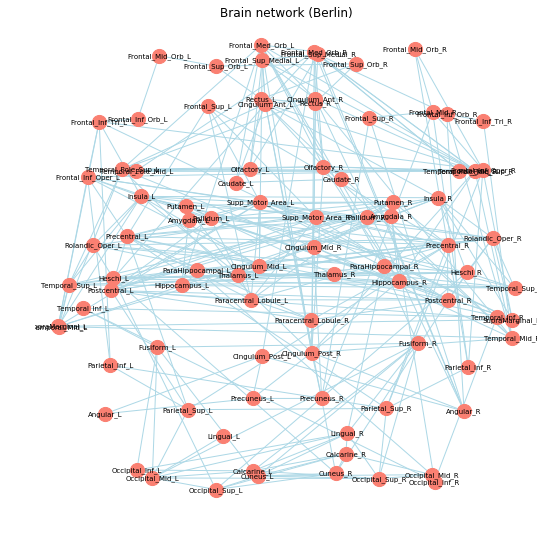

In [29]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


##### loading the network data
H = nx.read_adjlist('DataRichClub/Berlin_sub91116_aal90_d5_annotated.adjlist')
# extracting giant component nodes
GCnodes = max(nx.connected_components(H), key=len)  
# giant component as a network
G = H.subgraph(GCnodes)   


###### drawing the graph --- in the brain space
# loading the coordinates info for brain areas
AALTable = pd.read_csv('DataRichClub/aal_MNI_V4_coord.csv')
# dictionary of xy-coordinates
pos = {}
for i in range(1,91):
    pos[AALTable.iloc[i-1,1]] = np.array(AALTable.loc[i-1,
                                                      ['centerX',
                                                       'centerY']])

# Actual drawing
plt.figure(figsize=[9,9])
nx.draw_networkx_nodes(G, pos, node_color='salmon', node_size=200)
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')
plt.axis('off')
plt.title('Brain network (Berlin)')
plt.show()


Now let's calculate core numbers.

In [30]:
##### K-core number
KcoreDict = nx.core_number(G)
listCoreNum = [kc for kc in KcoreDict.values()]
minKCore = min(listCoreNum)
maxKCore = max(listCoreNum)


In [31]:
minKCore

1

In [32]:
maxKCore

7

In this network, the core number ranges between 1 and 7. We shall focus on higher core numbers only (5 or larger) to visualize the K-core of this network. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


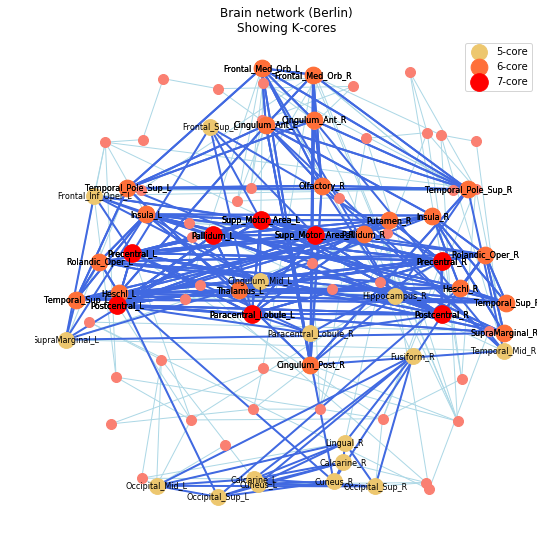

In [33]:

###### drawing the graph (K-Core)
node_color_list = get_cmap(maxKCore+1,'rainbow')
plt.figure(figsize=[9,9])
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
nx.draw_networkx_nodes(G, pos, node_color='salmon', node_size=100)
# k-core nodes
for iCore in range(5,maxKCore+1):
    nodeCore = [node for node, coreNum in KcoreDict.items()
                if coreNum>=iCore]
    subG = G.subgraph(nodeCore)
    nx.draw_networkx_nodes(subG, pos, node_color=node_color_list(iCore),
                           node_size=100+iCore*30, label=str(iCore)+'-core')
    nx.draw_networkx_labels(subG, pos, font_size=8, 
                            font_color='black', font_weight='normal')
    nx.draw_networkx_edges(subG, pos, width=2.0, edge_color='royalblue')
plt.axis('off')
plt.title('Brain network (Berlin)\nShowing K-cores')
plt.legend()
plt.show()

### Exercise
**K-Core, brain network**. Examine the k-core subnetwork of the brain network with higher edge density (d10 or d15). Produce a network drawing of the k-core nodes (similar to the one above) and post it as an attachment on the discussion on Canvas. Note that you may need to increase k when producing the output. Does an increase in the edge density expand the k-core?

# *Further readings*
<hr style="height:1px;border:none" />

* van den Heuvel MP, Sporns O. 2011. Rich-Club Organization of the Human Connectome. J Neurosci 31: 15775-15786.
* Kitsak et al., 2010. Identification of influential spreaders in complex networks. Nature Physics 6: 888-893